# Hugging Face 🤗 - Sentiment Analysis Using Vader, Roberta & Bert

* **Vader:** This model provides negativity, neutrality, and positivity scores to evaluate the sentiment of a sentence. It also includes a *`compound`* score, which represents a synthesis of the previous three scores. The *`compound`* score ranges between -1 and 1, where -1 indicates extremely negative sentiment, 1 indicates extremely positive sentiment, and 0 indicates complete neutrality.

* **Roberta:** Similar to Vader in terms of functionality, Roberta is a more advanced version that offers enhanced sentiment detection capabilities. However, unlike Vader, Roberta does not calculate a *`compound`* score. This model is optimized to handle more complex language and capture subtle nuances in texts.

* **Bert:** Bert specializes in product review analysis, supporting six languages: English, Dutch, German, French, Spanish and Italian. This model predicts the sentiment expressed in a review as a star rating, ranging from 1 to 5, where 1 is the most negative and 5 is the most positive.


**Choice of models:**

* Bert is particularly effective at analyzing product reviews, especially if your data is multilingual (English, Dutch, German, French, Spanish, Italian). It works well when you need results in the form of a star rating, which can be intuitive for tasks related to customer satisfaction or product review. Bert is a model that interprets reviews in a gradual manner, which is useful for recommendation systems

* Roberta (best model), being an improved version of the BERT model (on which it is based), generally performs better at understanding more subtle nuances in text. Roberta is not limited to a specific type of text like Bert with Product Reviews, making it more versatile for various types of text data, including news articles, tweets, or conversations.

* Vader particularly excels with short, informal texts, like tweets or social media comments, as it is specifically designed to interpret everyday language and emojis frequently used in these types of communication. Vader is designed to be lightweight and fast, making it ideal for applications requiring real-time responses or processing large volumes of data quickly.

# 1. Vader

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer() 

In [2]:
# positive sentence
pos_sentence = 'This men is so beautiful'
sid.polarity_scores(pos_sentence)

{'neg': 0.0, 'neu': 0.445, 'pos': 0.555, 'compound': 0.7177}

In [3]:
# negative sentence
neg_sentence = 'It’s a shitty movie! what a waste of time, Fuck!'
sid.polarity_scores(neg_sentence)

{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'compound': -0.8881}

In [4]:
# neutral sentence
neutral_sentence = 'birds fly in the sky'
sid.polarity_scores(neutral_sentence)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [8]:
import pandas as pd

data = pd.read_csv('/Users/nathan/Desktop/UPDATED_NLP_COURSE/TextFiles/amazonreviews.tsv', sep = '\t')
data.head(3)

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...


In [6]:
data.label.value_counts(normalize = True)

neg    0.5097
pos    0.4903
Name: label, dtype: float64

In [7]:
# checking for blanck values

blanks = []

for index, first, sec in data.itertuples():
    if type(sec) == str:
        if sec.isspace():
            blanks.append(sec)
            
if any(blanks):
    print('There are blanks values')
else:
    print(None)

None


## Method Brut

In [8]:
dict_sentiment = {}

count_pos = 0
count_neg = 0

for element in data.review:
    sentence = element
    result = sid.polarity_scores(sentence).get('compound')
    if result > 0:
        count_pos += 1
    elif result < 0:
        count_neg += 1
        
dict_sentiment['Positive'] = count_pos
dict_sentiment['Negative'] = count_neg

dict_sentiment

{'Positive': 6795, 'Negative': 3064}

In [9]:
print(f'Positive: {dict_sentiment.get("Positive") / data.review.shape[0]:.2f}%')
print(f'Negative: {1 - (dict_sentiment.get("Positive") / data.review.shape[0]):.2f}%')

Positive: 0.68%
Negative: 0.32%


## Analyzing Vader

In [10]:
data['Vader_Results'] = data.review.apply(lambda x: sid.polarity_scores(x).get('compound'))
data['Results'] = data.Vader_Results.apply(lambda x: 'pos' if x > 0 else 'neg')
data.head()

,label,review,Vader_Results,Results
0,pos,Stuning even for the non-gamer: This sound tra...,0.9454,pos
1,pos,The best soundtrack ever to anything.: I'm rea...,0.8957,pos
2,pos,Amazing!: This soundtrack is my favorite music...,0.9858,pos
3,pos,Excellent Soundtrack: I truly like this soundt...,0.9814,pos
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",0.9781,pos


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


acc = accuracy_score(data.label, data.Results)
print(f'The Accuracy of the Vader method for this dataset is: {acc:.2f}%\n')
print(classification_report(data.label, data.Results)) # Plus de mal a identifier les négatifs`

The Accuracy of the Vader method for this dataset is: 0.71%

              precision    recall  f1-score   support

         neg       0.85      0.53      0.65      5097
         pos       0.65      0.90      0.75      4903

    accuracy                           0.71     10000
   macro avg       0.75      0.72      0.70     10000
weighted avg       0.75      0.71      0.70     10000



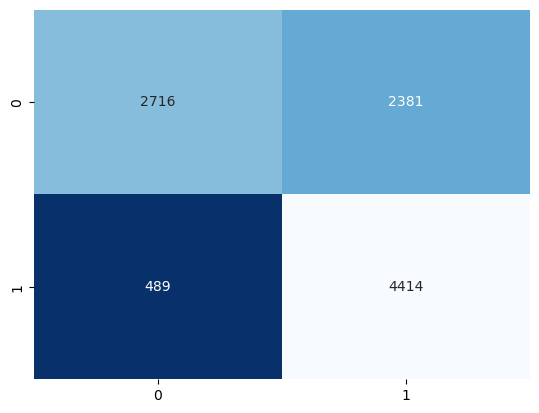

In [12]:
conf = confusion_matrix(data.label, data.Results)
sns.heatmap(conf, annot = True, fmt = 'g', cbar = False, cmap = 'Blues_r'); # a lot of negatives predicted as positives

# 2. Roberta Model - API

In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [6]:
def tokenize(x):
    '''
    Function to modelling data (by softmax) & return sentiment
    '''
    encode = tokenizer(x, return_tensors = 'pt')
    output = model(**encode)
    score = output.logits[0].detach().numpy()
    softmax_result = softmax(score)
    if softmax_result[0] > softmax_result[2]:
         return 'neg' 
    return 'pos'                                                                                                                                      

In [9]:
ROW = 500

lst_response = []
for i in range(0, ROW):
    response = tokenize(data.review[i])
    lst_response.append(response)

In [10]:
data2 = data[:ROW]

Roberta_Results = pd.DataFrame(lst_response, columns = ['Roberta_Results'])
data2 = pd.concat((data2, Roberta_Results), axis = 1)
data2.head()

,label,review,Roberta_Results
0,pos,Stuning even for the non-gamer: This sound tra...,pos
1,pos,The best soundtrack ever to anything.: I'm rea...,pos
2,pos,Amazing!: This soundtrack is my favorite music...,pos
3,pos,Excellent Soundtrack: I truly like this soundt...,pos
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",pos


In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

acc2 = accuracy_score(data2.label, data2.Roberta_Results)
print(f'The Accuracy of the Vader method for this dataset is: {acc2:.2f}%\n')
print(classification_report(data2.label, data2.Roberta_Results))

The Accuracy of the Vader method for this dataset is: 0.90%

              precision    recall  f1-score   support

         neg       0.91      0.88      0.89       247
         pos       0.89      0.92      0.90       253

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



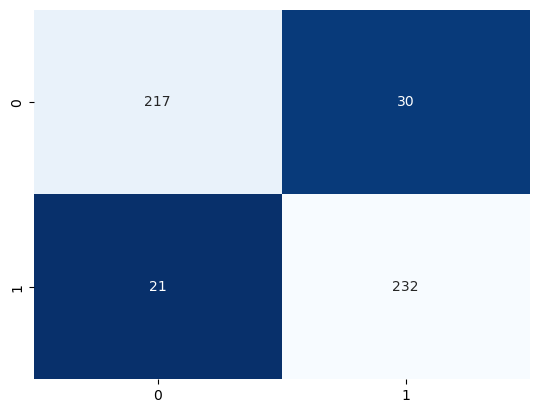

In [13]:
conf2 = confusion_matrix(data2.label, data2.Roberta_Results)
sns.heatmap(conf2, annot = True, fmt = 'g', cbar = False, cmap = 'Blues_r'); # beaucoup de négatif prédits comme positif

In [14]:
#data['Roberta_Results'] = data.review.apply(lambda x : tokenize(x))

# 3. Bert Model - API

**Il s'agit d'un modèle affiné pour l'analyse des sentiments sur les avis sur les produits en six langues : anglais, néerlandais, allemand, français, espagnol et italien. Il prédit le sentiment de la critique sous forme d'un nombre d'étoiles (entre 1 et 5).**

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re


tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [16]:
token = tokenizer('I love him!', return_tensors = 'pt')
output = model(**token)
output   # retourne les propabilité que la critique appartienne a chaque classe (plus élevé ici c'est 5 étoiles)

SequenceClassifierOutput(loss=None, logits=tensor([[-2.4654, -2.5802, -0.9555,  1.4687,  3.6366]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [17]:
stars_num = int(torch.argmax(output.logits)) + 1   #  add one because tensor start with 0
print(f'Cette phrase prédit une critique a {stars_num} étoiles')

Cette phrase prédit une critique a 5 étoiles


## Example with Beautiful Soup

In [ ]:
r = requests.get('https://www.yelp.com/biz/dumpling-baby-china-bistro-san-francisco-4?osq=Delivery')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')

In [ ]:
results = soup.find_all('p', {'class': regex})
reviews = [x.text for x in results]

In [ ]:
def reviews_function(x):
    token = tokenizer(x, return_tensors = 'pt')
    output = model(**token)
    stars_num = int(torch.argmax(output.logits)) + 1 
    return stars_num

In [ ]:
data_comment = pd.DataFrame(reviews, columns = ['Comment'])
data_comment['Stars'] = data_comment.Comment.apply(lambda x: reviews_function(x))
data_comment.head()